Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Model Development with Custom Weights

This example shows how to retrain a model with custom weights and fine-tune the model with quantization, then deploy the model running on FPGA. Only Windows is supported. We use TensorFlow and Keras to build our model. We are going to use transfer learning, with ResNet50 as a featurizer. We don't use the last layer of ResNet50 in this case and instead add our own classification layer using Keras.

The custom wegiths are trained with ImageNet on ResNet50. We are using a public Top tagging dataset as our training data.

Please set up your environment as described in the [quick start](project-brainwave-quickstart.ipynb).

This work was performed on the Caltech GPU cluster. The specific server is named imperium-sm.hep.caltech.edu. Paths have been set to work in that environment, but must be altered for your purposes.

In [1]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.backend import manual_variable_initialization
manual_variable_initialization(True)
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Setup Environment
After you train your model in float32, you'll write the weights to a place on disk. We also need a location to store the models that get downloaded.

In [2]:
# These directories were chosen because they write the data to local disk, which will have the fastest access time
# of our various storage options.
custom_weights_dir = os.path.expanduser("../weights-floatingpoint-224x224-fixval-best/")
custom_weights_dir_q = os.path.expanduser("../weights-quantized-224x224-fixval-best/")
saved_model_dir = os.path.expanduser("../machinelearningnotebooks/models/")
results_dir = os.path.expanduser("../results-quantized-224x224-fixval/")

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form.

At the time of writing, the files in question are located at `/data/shared/dwerran/converted`. They are stored in the HDF5 format, and must be accessed via the `tables` module. The two sub-datasets we're interested in are `/img-pt` and `/labels`, corresponding to the images and lables respectively. Each dataset contains 50000 images, and there are about 30 datasets. As before, this storage location was chosen to maximize data bandwidth.

In [3]:
from utils import normalize_and_rgb, image_with_label, count_events, save_results, plot_results

In [4]:
import glob
# for 64x64:
#datadir = "../data/"
# for 224x224:
datadir = "../../converted/rotation_224_v1/"
n_train_file = 122
n_test_file = 41
n_val_file = 41

train_files = glob.glob(os.path.join(datadir, 'train_file_*'))
test_files = glob.glob(os.path.join(datadir, 'test_file_*'))
val_files = glob.glob(os.path.join(datadir, 'val_file_*'))
#train_files = train_files[:n_train_file]
#test_files = test_files[:n_test_file]
#val_files = val_files[:n_val_file]

n_train_events = count_events(train_files)
n_test_events = count_events(test_files)
n_val_events = count_events(val_files)

print("n_train_events =", n_train_events)
print("n_test_events =", n_test_events)
print("n_val_events =", n_val_events)

n_train_events = 1211000
n_test_events = 404000
n_val_events = 403000


## Construct Model
We use ResNet50 for the featuirzer and build our own classifier using Keras layers. We train the featurizer and the classifier as one model. The weights trained on ImageNet are used as the starting point for the retraining of our featurizer. The weights are loaded from tensorflow checkpoint files.

Before passing image dataset to the ResNet50 featurizer, we need to preprocess the input file to get it into the form expected by ResNet50. ResNet50 expects float tensors representing the images in BGR, channel last order. Given that our images are greyscale, this isn't relevant to us, as we will simply be copying the data in place.

In [5]:
from utils import preprocess_images

We use Keras layer APIs to construct the classifier. Because we're using the tensorflow backend, we can train this classifier in one session with our Resnet50 model.

In [6]:
from utils import construct_classifier

Now every component of the model is defined, we can construct the model. Constructing the model with the project brainwave models is two steps - first we import the graph definition, then we restore the weights of the model into a tensorflow session. Because the quantized graph defintion and the float32 graph defintion share the same node names in the graph definitions, we can initally train the weights in float32, and then reload them with the quantized operations (which take longer) to fine-tune the model.

In [7]:
from utils import construct_model

## Train Model
First we train the model with custom weights but without quantization. Training is done with native float precision (32-bit floats). We load the traing data set and batch the training with 10 epochs. When the performance reaches desired level or starts decredation, we stop the training iteration and save the weights as tensorflow checkpoint files. 

In [8]:
from utils import chunks, train_model, test_model

This training currently leverages a hack to work around some apparent limits in the BW API. I have attempted to specify a custom weights directory when calling the `Resnet50` function in `construct_model()` above in the same way it is specified for `Quantized_Resnet50`. However, this throws an error, and since there is no API documentation yet, the way I'm working around it is rewriting our trained weights to the saved model directory. I will be reaching out to the team on this topic to see if they have a better suggestion.

In [ ]:
# Launch the training
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

num_epoch_train = 10

with sess.as_default():
    in_images, image_tensors, features, preds, featurizer, classifier = construct_model(quantized=False, saved_model_dir=saved_model_dir, is_training=True, size=224)
    # It's necessary to specify global (all) variables when using the saver in this instance.
    # Since we are using batch norm layers, whose variables aren't saved by default, we
    # include them this way.
    saver = tf.train.Saver(tf.global_variables(), max_to_keep = 100)
    loss_over_epoch, accuracy_over_epoch, auc_over_epoch, val_loss_over_epoch, val_accuracy_over_epoch, val_auc_over_epoch = \
        train_model(preds, in_images, train_files, val_files, is_retrain=False, train_epoch=num_epoch_train, 
                    classifier=classifier,
                    saver=saver, checkpoint_path=custom_weights_dir,
                    chunk_size=64) 
    _, _, features, preds, featurizer, classifier = construct_model(quantized=False, saved_model_dir=saved_model_dir, starting_weights_directory=custom_weights_dir, is_training=False, size=224)
    loss, accuracy, auc, preds_test, test_labels = test_model(preds, in_images, test_files)

INFO:tensorflow:Restoring parameters from ../machinelearningnotebooks/models/rn50/1.1.3/resnet50_bw


  8%|▊         | 1552/18922 [11:49<2:02:44,  2.36it/s]

## Load and Test Model
Here, we re-load the weights saved on disk and test the model. 

In [21]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading a trained model")
    in_images, image_tensors, features, preds, featurizer, classifier = construct_model(quantized=False, 
                                                                                        saved_model_dir=saved_model_dir, 
                                                                                        starting_weights_directory=custom_weights_dir, 
                                                                                        is_training=False, 
                                                                                        size=224)
    loss, accuracy, auc, preds_test, test_labels = test_model(preds, 
                                                              in_images, 
                                                              test_files, 
                                                              chunk_size=64, 
                                                              shuffle=False)
    print("Accuracy:", accuracy, ", Area under ROC curve:", auc)
    
# Call the save results utility.
save_results(results_dir, 't', accuracy, test_labels, preds_test)

Loading a trained model
INFO:tensorflow:Restoring parameters from ../weights-floatingpoint-224x224-fixval-best/resnet50_bw
loading classifier weights from ../weights-floatingpoint-224x224-fixval-best//class_weights.h5


 97%|█████████▋| 6126/6313 [22:40<00:46,  3.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.9008886138613243


## Load and Test Quantized Model (with Floating Point Weights)
After training, we evaluate the trained model's accuracy on test dataset with quantization. So that we know the model's performance if it is deployed on the FPGA. The only significant difference between this cell and the cell two below is this loads weights from the floating point directory and the one two below loads from the quantized directory. In this way, you can compare pre- and post- quantization fine tuning tests.

It's been found that an abysmal score here does not necessarily reflect a broken model. Quantization has very negative effects on the batch normalization layers, and should quickly be corrected in only a few epochs of fine-tuning.

In [25]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading a trained model (quantized)")
    in_images_q, image_tensors_q, features_q, preds_q, featurizer_q, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir, 
                                                                                                  is_training=False, 
                                                                                                  size=224)
    loss_q, accuracy_q, auc_q, preds_test_q, test_labels_q = test_model(preds_q, 
                                                                        in_images_q, 
                                                                        test_files,
                                                                        chunk_size=64, 
                                                                        shuffle=False)
    print("Accuracy:", accuracy_q, ", Area under ROC curve:", auc_q)
    
# Call the save results utility.
save_results(results_dir, 'q', accuracy_q, test_labels_q, preds_test_q)

Loading a trained model (quantized)
INFO:tensorflow:Restoring parameters from ../weights-floatingpoint-224x224-fixval-best/resnet50_bw
loading classifier weights from ../weights-floatingpoint-224x224-fixval-best//class_weights.h5


 53%|█████▎    | 3316/6313 [27:09<25:41,  1.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Fine-Tune Quantized Model
Sometimes, the model's accuracy can drop significantly after quantization. In those cases, we need to retrain the model enabled with quantization to get better model accuracy.

In [ ]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

num_epoch_finetune = 10

with sess.as_default():
    print("Fine-tuning model with quantization")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir, 
                                                                                                  is_training=True, 
                                                                                                  size=224)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep = 100)
    loss_over_epoch_ft, accuracy_over_epoch_ft, auc_over_epoch_ft, val_loss_over_epoch_ft, val_accuracy_over_epoch_ft, val_auc_over_epoch_ft = \
        train_model(preds, in_images, train_files, val_files, is_retrain=True, train_epoch=num_epoch_finetune, 
                    classifier=classifier,
                    saver=saver, 
                    checkpoint_path=custom_weights_dir_q,
                    chunk_size=32) 

Fine-tuning model with quantization
INFO:tensorflow:Restoring parameters from ../weights-floatingpoint-224x224-fixval-best/resnet50_bw
loading classifier weights from ../weights-floatingpoint-224x224-fixval-best//class_weights.h5


 48%|████▊     | 18047/37844 [1:47:52<1:57:34,  2.81it/s]

## Load and Test Quantized Model
After training, we evaluate the trained model's accuracy on test dataset with quantization. So that we know the model's performance if it is deployed on the FPGA. The only significant difference between this cell and the cell two above is this loads weights from the quantized directory and the one two above loads from the floating point directory. In this way, you can compare pre- and post- quantization fine tuning tests.

In [9]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())
with sess.as_default():
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir_q, 
                                                                                                  is_training=False, 
                                                                                                  size=224)
    loss_ft, accuracy_ft, auc_ft, preds_test_ft, test_labels_ft = test_model(preds, 
                                                                             in_images, 
                                                                             test_files,
                                                                             chunk_size=64, 
                                                                             shuffle=False)
    
# Call the save results utility.
save_results(results_dir, 'ft', accuracy_ft, test_labels_ft, preds_test_ft)

INFO:tensorflow:Restoring parameters from ../weights-quantized-224x224-fixval-best/resnet50_bw
loading classifier weights from ../weights-quantized-224x224-fixval-best//class_weights.h5


 53%|█████▎    | 3344/6313 [27:42<24:34,  2.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Floating Point 0.9008886138613243 0.9796892626772323 0.300000989677662 670.8106312292358
Quantized      0.841301980197959 0.9754306154368404 0.30008511227893075 414.60780287474336
Quantized, fine-tuned 0.9295990099009257 0.9824656282917309 0.29999604128935203 970.7403846153848


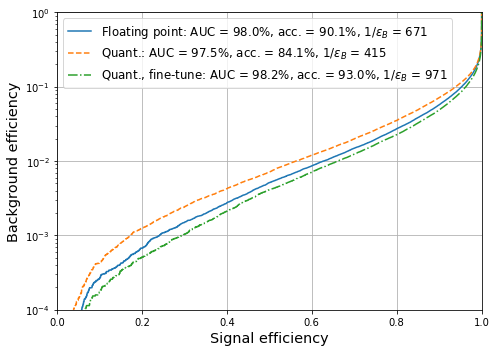

In [10]:
%matplotlib inline


#from utils import plot_results
def plot_results(results_dir,plot_label='ROC.pdf'):
    import os
    import numpy as np
    from sklearn import metrics

    # Load the labels and results into memory.
    accuracy_t     = np.load(results_dir + "/t_accuracy.npy")
    test_labels_t  = np.load(results_dir + "/t_labels.npy")
    test_preds_t   = np.load(results_dir + "/t_preds.npy")
    accuracy_q     = np.load(results_dir + "/q_accuracy.npy")
    test_labels_q  = np.load(results_dir + "/q_labels.npy")
    test_preds_q   = np.load(results_dir + "/q_preds.npy")
    accuracy_ft     = np.load(results_dir + "/ft_accuracy.npy")
    test_labels_ft = np.load(results_dir + "/ft_labels.npy")
    test_preds_ft  = np.load(results_dir + "/ft_preds.npy")
    #accuracy_b     = np.load(results_dir + "/b_accuracy.npy")
    #test_labels_b = np.load(results_dir + "/b_labels.npy")
    #test_preds_b  = np.load(results_dir + "/b_preds.npy")

    new_test_preds_t = np.zeros(test_preds_t.shape)
    new_test_preds_t[:,0] = test_preds_t[:,0]/np.sum(test_preds_t,axis=1)
    new_test_preds_t[:,1] = test_preds_t[:,1]/np.sum(test_preds_t,axis=1)
    test_preds_t = new_test_preds_t

    new_test_preds_q = np.zeros(test_preds_q.shape)
    new_test_preds_q[:,0] = test_preds_q[:,0]/np.sum(test_preds_q,axis=1)
    new_test_preds_q[:,1] = test_preds_q[:,1]/np.sum(test_preds_q,axis=1)
    test_preds_q = new_test_preds_q

    new_test_preds_ft = np.zeros(test_preds_ft.shape)
    new_test_preds_ft[:,0] = test_preds_ft[:,0]/np.sum(test_preds_ft,axis=1)
    new_test_preds_ft[:,1] = test_preds_ft[:,1]/np.sum(test_preds_ft,axis=1)
    test_preds_ft = new_test_preds_ft

    #new_test_preds_b = np.zeros(test_preds_b.shape)
    #new_test_preds_b[:,0] = test_preds_b[:,0]/np.sum(test_preds_b,axis=1)
    #new_test_preds_b[:,1] = test_preds_b[:,1]/np.sum(test_preds_b,axis=1)
    #test_preds_b = new_test_preds_b
    
    # Determine the ROC curve for each of the tests. 
    # [:,0] will convert the labels from one-hot to binary.
    fpr_test_t, tpr_test_t, thresholds      = metrics.roc_curve(test_labels_t[:,0],  test_preds_t[:,0])
    fpr_test_q, tpr_test_q, thresholds_q    = metrics.roc_curve(test_labels_q[:,0],  test_preds_q[:,0])
    fpr_test_ft, tpr_test_ft, thresholds_ft    = metrics.roc_curve(test_labels_ft[:,0],  test_preds_ft[:,0])
    #fpr_test_b, tpr_test_b, thresholds_b    = metrics.roc_curve(test_labels_b[:,0],  test_preds_b[:,0])
    
    # Use the data we just generated to determine the area under the ROC curve.
    # Use the data we just generated to determine the area under the ROC curve.
    auc_test    = metrics.auc(fpr_test_t, tpr_test_t)
    auc_test_q  = metrics.auc(fpr_test_q, tpr_test_q)
    auc_test_ft  = metrics.auc(fpr_test_ft, tpr_test_ft)
    #auc_test_b  = metrics.auc(fpr_test_b, tpr_test_b)
    
    # Find the true positive rate of 30% and 1 over the false positive rate at tpr = 30%.
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    idx_t    = find_nearest(tpr_test_t,0.3)
    idx_q    = find_nearest(tpr_test_q,0.3)
    idx_ft   = find_nearest(tpr_test_ft,0.3)
    #idx_b    = find_nearest(tpr_test_b,0.3)
    
    # Plot the ROCs, labeling with the AUCs.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    plt.plot(tpr_test_t, fpr_test_t, label=r'Floating point: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test*100., accuracy_t*100, 1./fpr_test_t[idx_t]))
    plt.plot(tpr_test_q, fpr_test_q, linestyle='--', label=r'Quant.: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_q*100., accuracy_q*100, 1./fpr_test_q[idx_q]))
    plt.plot(tpr_test_ft, fpr_test_ft, linestyle='-.', label=r'Quant., fine-tune: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_ft*100., accuracy_ft*100, 1./fpr_test_ft[idx_ft]))
    #plt.plot(tpr_test_b, fpr_test_b, linestyle=':',label=r'Brainwave: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_b*100., accuracy_b*100, 1./fpr_test_b[idx_b]))
    plt.semilogy()
    plt.xlabel("Signal efficiency",fontsize='x-large')
    plt.ylabel("Background efficiency",fontsize='x-large')
    plt.ylim(0.0001,1)
    plt.xlim(0,1)
    plt.grid(True)
    plt.legend(loc='upper left',fontsize=11.8)
    plt.tight_layout()
    plt.savefig(results_dir+'/'+plot_label)    
    #plt.figure()
    #plt.hist(test_preds_t[:,0], weights=test_labels_t[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_t[:,0], weights=test_labels_t[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_q[:,0], weights=test_labels_q[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_q[:,0], weights=test_labels_q[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_ft[:,0], weights=test_labels_ft[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_ft[:,0], weights=test_labels_ft[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_b[:,0], weights=test_labels_b[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_b[:,0], weights=test_labels_b[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)

    print ("Floating Point", accuracy_t, auc_test, tpr_test_t[idx_t], 1./fpr_test_t[idx_t])
    print ("Quantized     ", accuracy_q, auc_test_q, tpr_test_q[idx_q], 1./fpr_test_q[idx_q])
    print ("Quantized, fine-tuned", accuracy_ft, auc_test_ft, tpr_test_ft[idx_ft], 1./fpr_test_ft[idx_ft])
    #print ("Brainwave", accuracy_b, auc_test_b, tpr_test_b[idx_b], 1./fpr_test_b[idx_b])
    
plot_results(results_dir)

## Appendix

License for plot_confusion_matrix:

New BSD License

Copyright (c) 2007-2018 The scikit-learn developers.
All rights reserved.


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

  a. Redistributions of source code must retain the above copyright notice,
     this list of conditions and the following disclaimer.
  b. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in the
     documentation and/or other materials provided with the distribution.
  c. Neither the name of the Scikit-learn Developers  nor the names of
     its contributors may be used to endorse or promote products
     derived from this software without specific prior written
     permission. 


THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL THE REGENTS OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY
OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH
DAMAGE.
